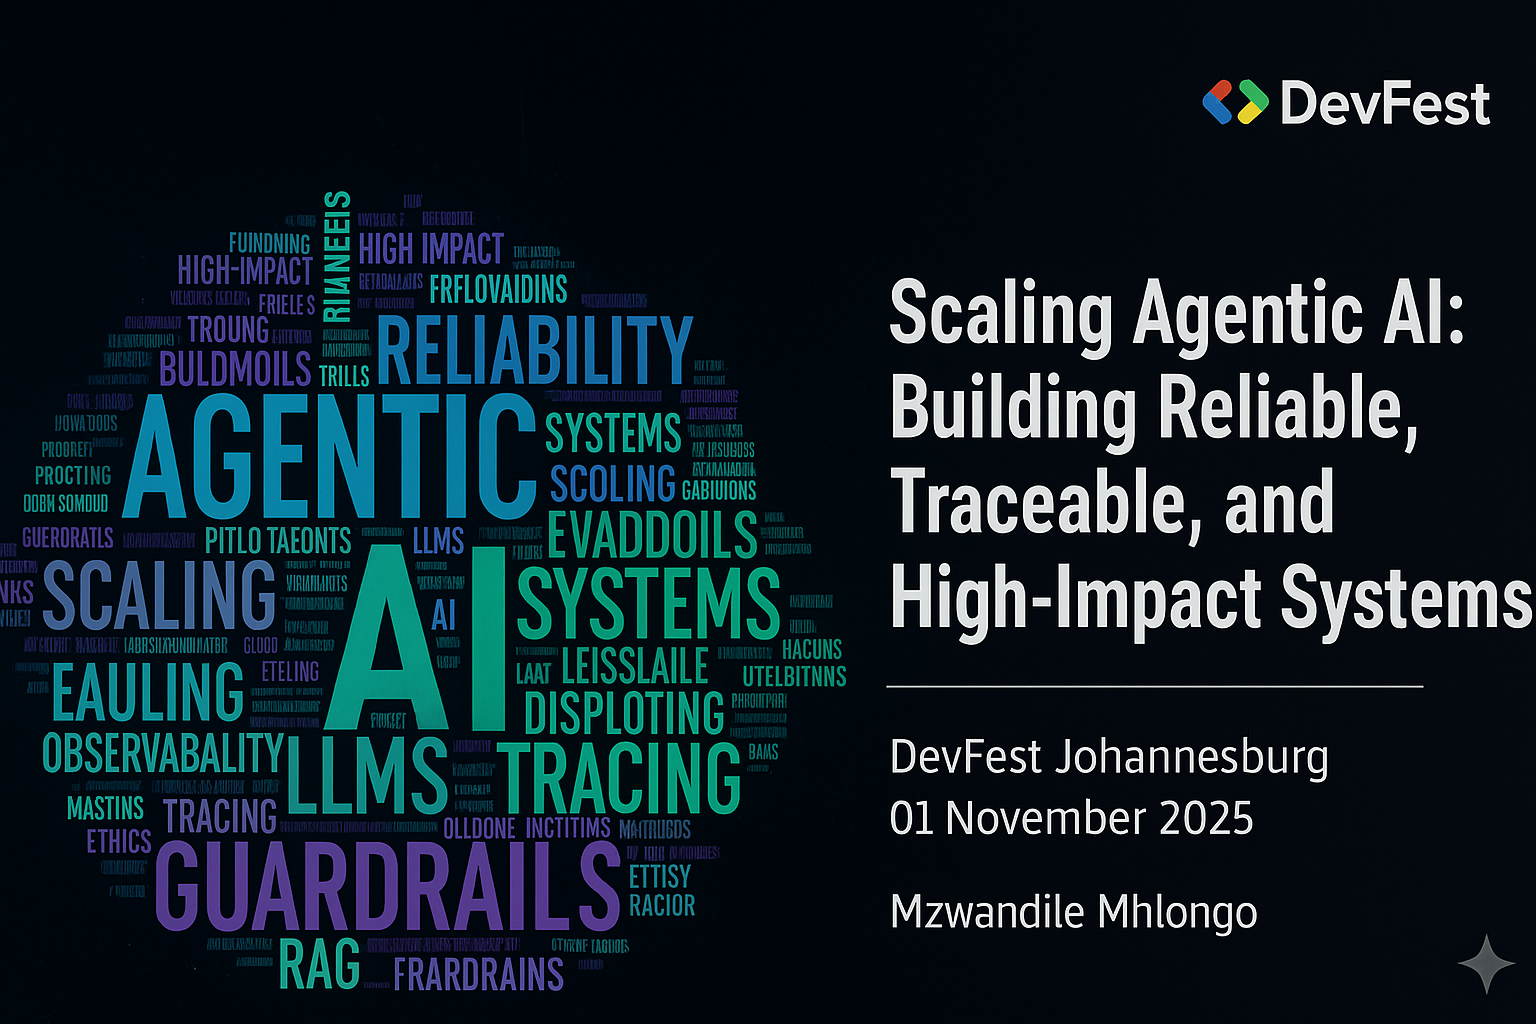

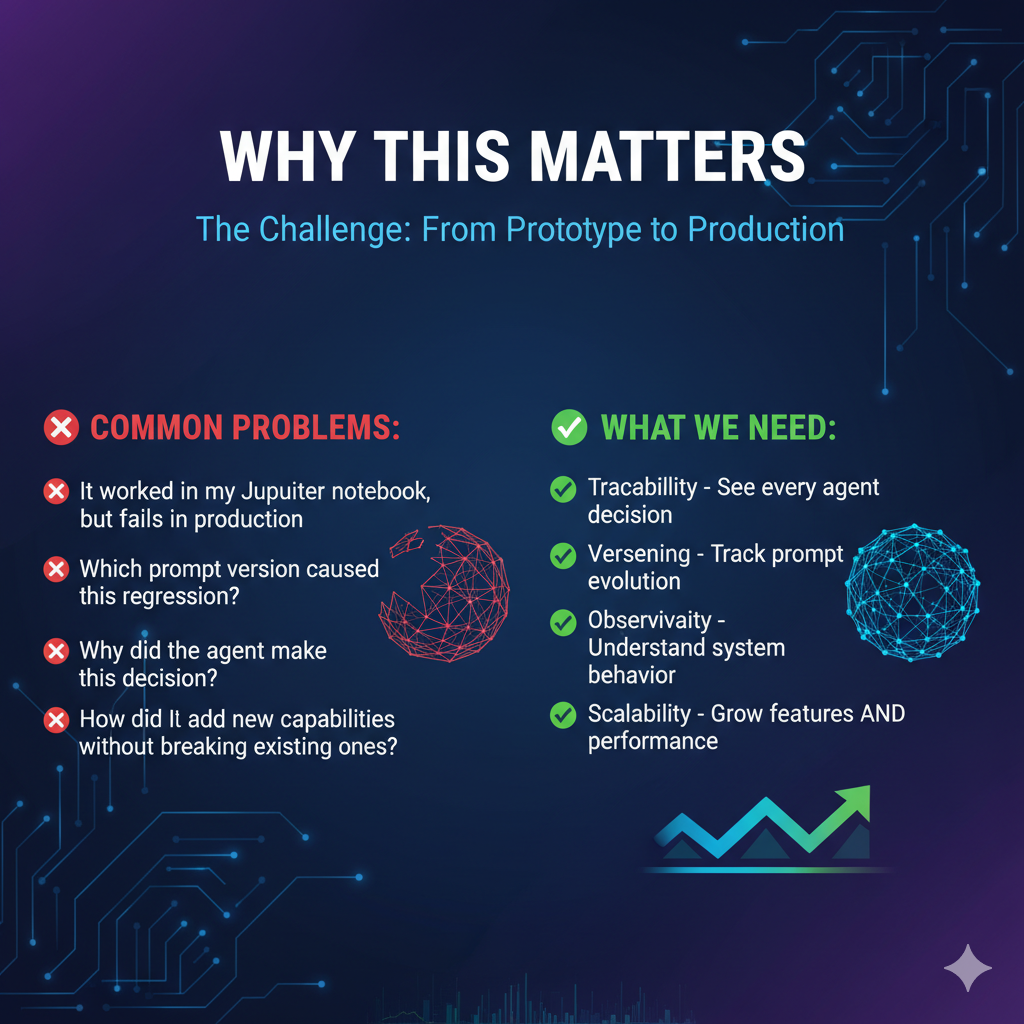

In [8]:
from IPython.display import Image, display

image_path1 = "/Users/mzwandilemhlongo/Desktop/Data Science/PersonalProjects/ai-powered-analysis/text2sql/ai-analyst-agent/presentation/Presentation.png"
image_path2 = "/Users/mzwandilemhlongo/Desktop/Data Science/PersonalProjects/ai-powered-analysis/text2sql/ai-analyst-agent/presentation/WhyThisMatter.png"

display(Image(filename=image_path1, width=1500, height=500))
display(Image(filename=image_path2))

pok# Scaling Agentic AI: Live Demo
## Building Reliable, Traceable, and High-Impact Systems

This notebook demonstrates three layers of agentic AI evolution:
1. **Layer 1:** Simple LLM (No memory, no tools)
2. **Layer 2:** Single Agent (Memory + Tools)
3. **Layer 3:** Multi-Agent System (Router + Specialized Agents)

---

## Setup: Install Required Packages

In [ ]:
# Install required packages
# !pip install openai mlflow chromadb python-dotenv -q

## Import Libraries

In [1]:
import os
import json
from openai import OpenAI
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))



print("✅ Setup complete!")

✅ Setup complete!


---
# Layer 1: Simple LLM
## No Memory, No Tools, No Context

**Use Case:** Basic question answering  
**Limitations:** 
- No conversation history
- No access to external data
- No specialized capabilities



In [9]:
def simple_llm(user_query):
    """
    Layer 1: Basic LLM with no enhancements
    """
    print("🔵 LAYER 1: Simple LLM")
    print(f"User Query: {user_query}\n")
    
    response = client.responses.create(
        model="gpt-4.1",
        input=user_query
    )
    
    # print(f"Response: {response.output_text}")

    return response.output_text

In [10]:
# Demo 1: Single question
simple_llm("What are the total sales for Q4 2024?")

🔵 LAYER 1: Simple LLM
User Query: What are the total sales for Q4 2024?



"It looks like you’re referencing sales data for Q4 2024, but I don't see any data or attachments in your message. Could you please provide the relevant sales figures, table, file, or screenshot? Then I can help you calculate the total sales for Q4 2024!"

In [11]:
# Demo 2: Follow-up question (no memory)
print("\n" + "="*50)
simple_llm("How does that compare to Q3?")  # ❌ No context from previous question


🔵 LAYER 1: Simple LLM
User Query: How does that compare to Q3?



'It looks like your question refers to a comparison with "Q3," but I don\'t have the context for what "that" specifically refers to. Could you clarify what data, metric, or subject you\'re referring to for the comparison between Q3 and the current period (Q4, perhaps)? If you can provide the details or numbers for the comparison, I can help analyze or summarize the differences for you!'

### ❌ Problem Demonstrated:
The LLM has no memory of the previous question. It doesn't know what "that" refers to.

---
# Layer 2: Single Agent with Memory + Tools
## Context-Aware Agent with Function Calling

**Enhancements:**
- 💾 Conversation memory
- 🛠️ Access to tools (SQL, Calculator, Search)
- 🧠 Can decide when to use tools

In [12]:
import mlflow
# Enable MLflow tracing
mlflow.openai.autolog()

In [13]:
# Define available tools
tools = [
    {
        "type": "function",
        "name": "execute_sql",
        "description": "Execute a SQL query against the database to retrieve data",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The SQL query to execute"
                },
                "database": {
                    "type": "string",
                    "description": "Database name (e.g., 'sales', 'analytics')"
                }
            },
            "required": ["query", "database"]
        }
    },
    {
        "type": "function",
        "name": "calculate",
        "description": "Perform mathematical calculations",
        "parameters": {
            "type": "object",
            "properties": {
                "expression": {
                    "type": "string",
                    "description": "Mathematical expression to evaluate"
                }
            },
            "required": ["expression"]
        }
    }
]

print("✅ Tools defined:")
for tool in tools:
    print(f"  - {tool['name']}: {tool['description']}")

✅ Tools defined:
  - execute_sql: Execute a SQL query against the database to retrieve data
  - calculate: Perform mathematical calculations


In [16]:
# Mock tool implementations
def execute_sql(query, database):
    """
    Mock SQL execution - simulates database query
    """
    print(f"\n🔧 Executing SQL on {database}:")
    print(f"   Query: {query}")
    
    # Simulate query results
    mock_results = {
        "Q4 2024": {"total_sales": 1250000, "orders": 3420},
        "Q3 2024": {"total_sales": 980000, "orders": 2890}
    }
    
    if "Q4" in query:
        return json.dumps(mock_results["Q4 2024"])
    elif "Q3" in query:
        return json.dumps(mock_results["Q3 2024"])
    else:
        return json.dumps({"total_sales": 1250000})

def calculate(expression):
    """
    Safe calculator function
    """
    print(f"\n🧮 Calculating: {expression}")
    try:
        result = eval(expression, {"__builtins__": {}}, {})
        return json.dumps({"result": result})
    except Exception as e:
        return json.dumps({"error": str(e)})

In [17]:
class AgentWithMemory:
    """
    Layer 2: Agent with conversation memory and tool access
    """
    def __init__(self):
        self.conversation_history = []
    
    @mlflow.trace(name="agent_with_tools", span_type="AGENT")
    def chat(self, user_message):
        print("🟢 LAYER 2: Agent with Memory + Tools")
        print(f"User: {user_message}\n")
        
        # Add user message to history
        self.conversation_history.append({
            "role": "user",
            "content": user_message
        })
        
        # Initial LLM call with tools
        response = client.responses.create(
            model="gpt-4.1",
            tools=tools,
            input=self.conversation_history
        )
        
        # Process tool calls if any
        if response.output:
            self.conversation_history += response.output
            
            for item in response.output:
                if item.type == "function_call":
                    print(f"\n🤖 Agent Decision: Call tool '{item.name}'")
                    
                    # Execute the appropriate tool
                    if item.name == "execute_sql":
                        args = json.loads(item.arguments)
                        result = execute_sql(args['query'], args['database'])
                    elif item.name == "calculate":
                        args = json.loads(item.arguments)
                        result = calculate(args['expression'])
                    else:
                        result = json.dumps({"error": "Unknown tool"})
                    
                    # Add tool result to conversation
                    self.conversation_history.append({
                        "type": "function_call_output",
                        "call_id": item.call_id,
                        "output": result
                    })
            
            # Get final response after tool execution
            final_response = client.responses.create(
                model="gpt-4o",
                tools=tools,
                input=self.conversation_history
            )
            
            print(f"\n✅ Agent Response: {final_response.output_text}")
            self.conversation_history.append({
                "role": "assistant",
                "content": final_response.output_text
            })
            
            return final_response.output_text
        else:
            # No tools needed
            print(f"\n✅ Agent Response: {response.output_text}")

            self.conversation_history.append({
                "role": "assistant",
                "content": response.output_text
            })
            return response.output_text
    
    def show_memory(self):
        """Display conversation history"""
        print("\n💾 Conversation Memory:")
        for msg in self.conversation_history:
            if isinstance(msg, dict) and 'role' in msg:
                print(f"  {msg['role']}: {msg['content'][:80]}...")

In [18]:
# Demo: Create agent and have a conversation
agent = AgentWithMemory()

# First question - agent uses SQL tool
agent.chat("What are the total sales for Q4 2024?")

🟢 LAYER 2: Agent with Memory + Tools
User: What are the total sales for Q4 2024?


🤖 Agent Decision: Call tool 'execute_sql'

🔧 Executing SQL on sales:
   Query: SELECT SUM(sales_amount) as total_sales FROM sales WHERE sale_date >= '2024-10-01' AND sale_date <= '2024-12-31';

✅ Agent Response: The total sales for Q4 2024 are $1,250,000.


'The total sales for Q4 2024 are $1,250,000.'

Trace(trace_id=tr-631b2b6907719d4ce0051af3c0c869be)

In [19]:
# Follow-up question - agent remembers context!
print("\n" + "="*70 + "\n")
agent.chat("How does that compare to Q3?")



🟢 LAYER 2: Agent with Memory + Tools
User: How does that compare to Q3?


🤖 Agent Decision: Call tool 'execute_sql'

🔧 Executing SQL on sales:
   Query: SELECT SUM(sales_amount) as total_sales FROM sales WHERE sale_date >= '2024-07-01' AND sale_date <= '2024-09-30';

✅ Agent Response: The total sales for Q3 2024 are also $1,250,000, which is the same as Q4 2024.


'The total sales for Q3 2024 are also $1,250,000, which is the same as Q4 2024.'

Trace(trace_id=tr-37d943a90f5fb11e4268067da0c3412e)

In [20]:
# Calculate growth percentage
print("\n" + "="*70 + "\n")
agent.chat("What's the percentage growth?")



🟢 LAYER 2: Agent with Memory + Tools
User: What's the percentage growth?


🤖 Agent Decision: Call tool 'calculate'

🧮 Calculating: ((1250000 - 1250000) / 1250000) * 100

✅ Agent Response: There is a 0% growth from Q3 to Q4 2024, as the sales figures are identical.


'There is a 0% growth from Q3 to Q4 2024, as the sales figures are identical.'

Trace(trace_id=tr-f7c021e757114a77ab7de2b28755d9c6)

In [21]:
# Show conversation memory
agent.show_memory()


💾 Conversation Memory:
  user: What are the total sales for Q4 2024?...
  assistant: The total sales for Q4 2024 are $1,250,000....
  user: How does that compare to Q3?...
  assistant: The total sales for Q3 2024 are also $1,250,000, which is the same as Q4 2024....
  user: What's the percentage growth?...
  assistant: There is a 0% growth from Q3 to Q4 2024, as the sales figures are identical....


### ✅ Improvements Demonstrated:
1. **Memory:** Agent remembers previous questions
2. **Tool Use:** Automatically calls SQL and calculator tools
3. **Context Awareness:** Understands references like "that" and "the percentage"
4. **Traceability:** MLflow captures all decisions and tool calls

---
# Layer 3: Multi-Agent System
## Router + Specialized Agents

**Architecture:**
- 🎯 **Router Agent:** Delegates tasks to specialized agents
- 📊 **SQL Agent:** Handles database queries (Text2SQL)
- 📚 **RAG Agent:** Retrieves information from documents
- 🌐 **Web Search Agent:** Searches the internet for current information
- 🔄 **Consolidator:** Merges outputs from multiple agents

In [30]:
# Define specialized agent tools

class SQLAgent:
    """Specialized agent for SQL queries"""
    
    @mlflow.trace(name="sql_agent", span_type="AGENT")
    def execute(self, task):
        print("\n📊 SQL Agent activated")
        print(f"   Task: {task}")
        
        # Generate and execute SQL
        sql_query = f"SELECT SUM(amount) as total FROM sales WHERE quarter = 'Q4 2024'"
        result = execute_sql(sql_query, "sales_db")
        
        return {
            "agent": "SQL",
            "result": result,
            "query_used": sql_query
        }

class RAGAgent:
    """Specialized agent for document retrieval"""
    
    @mlflow.trace(name="rag_agent", span_type="AGENT")
    def execute(self, task):
        print("\n📚 RAG Agent activated")
        print(f"   Task: {task}")
        
        # Simulate vector search
        print("   🔍 Searching ChromaDB for relevant documents...")
        
        # Mock retrieved context
        context = """
        Q4 2024 Performance Summary:
        - Total revenue increased 27.5% YoY
        - Top performing region: North America
        - New customer acquisition: +15%
        - Product category leader: Electronics (40% of sales)
        """
        
        return {
            "agent": "RAG",
            "result": context.strip(),
            "sources": ["Q4_2024_report.pdf", "sales_summary.md"]
        }

class WebSearchAgent:
    """Specialized agent for web search"""
    
    @mlflow.trace(name="web_search_agent", span_type="AGENT")
    def execute(self, task):
        print("\n🌐 Web Search Agent activated")
        print(f"   Task: {task}")
        
        # Use OpenAI's built-in web search
        response = client.responses.create(
            model="gpt-4o",
            tools=[{"type": "web_search"}],
            input=task
        )
        
        return {
            "agent": "WebSearch",
            "result": response.output_text,
            "sources": ["web_search"]
        }

print("✅ Specialized agents initialized")

✅ Specialized agents initialized


In [33]:
class MultiAgentSystem:
    """
    Layer 3: Multi-agent orchestration system
    """
    def __init__(self):
        self.sql_agent = SQLAgent()
        self.rag_agent = RAGAgent()
        self.web_search_agent = WebSearchAgent()
        self.conversation_history = []
    
    @mlflow.trace(name="router_agent", span_type="AGENT")
    def route_task(self, user_query):
        """
        Router agent decides which specialized agents to activate
        """
        print("🎯 ROUTER AGENT: Analyzing query...")
        
        # Define routing tool
        routing_tool = [
            {
                "type": "function",
                "name": "delegate_tasks",
                "description": "Delegate tasks to specialized agents",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "tasks": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "agent": {
                                        "type": "string",
                                        "enum": ["sql", "rag", "web_search"],
                                        "description": "Which agent to use"
                                    },
                                    "task": {
                                        "type": "string",
                                        "description": "Task description for the agent"
                                    }
                                },
                                "required": ["agent", "task"]
                            }
                        }
                    },
                    "required": ["tasks"]
                }
            }
        ]
        
        # Router decides which agents to use
        routing_prompt = f"""
        You are a router agent. Analyze this query and determine which specialized agents to use:
        
        Query: {user_query}
        
        Available agents:
        - sql: For database queries and numerical data
        - rag: For retrieving context from internal documents
        - web_search: For current information from the internet
        
        Delegate appropriate tasks to each agent.
        """
        
        response = client.responses.create(
            model="gpt-4.1",
            tools=routing_tool,
            input=routing_prompt
        )
        
        # Extract routing decisions
        delegated_tasks = []
        if response.output:
            for item in response.output:
                if item.type == "function_call" and item.name == "delegate_tasks":
                    args = json.loads(item.arguments)
                    delegated_tasks = args.get('tasks', [])
        
        print(f"\n   📋 Delegating to {len(delegated_tasks)} agent(s)")
        return delegated_tasks
    
    @mlflow.trace(name="multi_agent_system", span_type="CHAIN")
    def process(self, user_query):
        """
        Main orchestration flow
        """
        print("🟣 LAYER 3: Multi-Agent System")
        print(f"User Query: {user_query}\n")
        print("="*70)
        
        # Step 1: Router delegates tasks
        tasks = self.route_task(user_query)
        
        # Step 2: Execute tasks in parallel (simulated)
        agent_results = []
        print("\n" + "="*70)
        print("⚙️  EXECUTING SUB-AGENTS")
        
        for task_info in tasks:
            agent_type = task_info['agent']
            task = task_info['task']
            
            if agent_type == "sql":
                result = self.sql_agent.execute(task)
            elif agent_type == "rag":
                result = self.rag_agent.execute(task)
            elif agent_type == "web_search":
                result = self.web_search_agent.execute(task)
            else:
                continue
            
            agent_results.append(result)
        
        # Step 3: Consolidate results
        print("\n" + "="*70)
        final_response = self.consolidate_results(user_query, agent_results)
        
        return final_response
    
    @mlflow.trace(name="consolidation_agent", span_type="AGENT")
    def consolidate_results(self, original_query, agent_results):
        """
        Consolidation agent merges outputs from all sub-agents
        """
        print("🔄 CONSOLIDATION AGENT: Merging results...\n")
        
        # Prepare context from all agents
        context = f"Original query: {original_query}\n\nResults from specialized agents:\n\n"
        
        for idx, result in enumerate(agent_results, 1):
            context += f"{idx}. {result['agent']} Agent:\n"
            context += f"   {result['result']}\n\n"
        
        # Generate consolidated response
        consolidation_prompt = f"""
        {context}
        
        Synthesize the above information into a comprehensive, coherent answer to the user's query.
        Include all relevant data points and insights from the specialized agents.
        """
        
        response = client.responses.create(
            model="gpt-4o",
            input=consolidation_prompt
        )
        
        print(f"✅ Final Consolidated Response:\n")
        print(response.output_text)
        
        return {
            "response": response.output_text,
            "agent_results": agent_results,
            "num_agents_used": len(agent_results)
        }

In [34]:
# Demo: Complex query requiring multiple agents
mas = MultiAgentSystem()

query = "Give me a comprehensive analysis of Q4 2024 sales performance with context from our reports"

result = mas.process(query)

🟣 LAYER 3: Multi-Agent System
User Query: Give me a comprehensive analysis of Q4 2024 sales performance with context from our reports

🎯 ROUTER AGENT: Analyzing query...

   📋 Delegating to 1 agent(s)

⚙️  EXECUTING SUB-AGENTS

📚 RAG Agent activated
   Task: Retrieve contextual insights, commentary, and analysis regarding Q4 2024 sales performance from our internal reports and documents.
   🔍 Searching ChromaDB for relevant documents...

🔄 CONSOLIDATION AGENT: Merging results...


   📋 Delegating to 1 agent(s)

⚙️  EXECUTING SUB-AGENTS

📚 RAG Agent activated
   Task: Retrieve contextual insights, commentary, and analysis regarding Q4 2024 sales performance from our internal reports and documents.
   🔍 Searching ChromaDB for relevant documents...

🔄 CONSOLIDATION AGENT: Merging results...

✅ Final Consolidated Response:

Q4 2024 Sales Performance Analysis:

In the fourth quarter of 2024, the company experienced remarkable growth, reflected in a 27.5% year-over-year increase in total rev

Trace(trace_id=tr-232ae3e0e679d3a06f67538e2f5547f2)

In [35]:
# Show which agents were used
print("\n" + "="*70)
print("📊 EXECUTION SUMMARY")
print("="*70)
print(f"\nAgents activated: {result['num_agents_used']}")
print("\nAgent breakdown:")
for agent_result in result['agent_results']:
    print(f"  ✓ {agent_result['agent']} Agent")
    if 'sources' in agent_result:
        print(f"    Sources: {', '.join(agent_result['sources'])}")


📊 EXECUTION SUMMARY

Agents activated: 1

Agent breakdown:
  ✓ RAG Agent
    Sources: Q4_2024_report.pdf, sales_summary.md


### ✅ Multi-Agent System Benefits:

1. **Task Specialization:** Each agent is optimized for specific tasks
2. **Parallel Execution:** Multiple agents can work simultaneously
3. **Modularity:** Easy to add new agents without changing existing ones
4. **Comprehensive Responses:** Combines data from multiple sources
5. **Full Traceability:** MLflow captures every agent decision and execution

---
# MLflow Tracing: View Agent Decisions

All agent executions are automatically traced by MLflow. To view traces:

```bash
mlflow ui
```

Then navigate to: http://localhost:5000

**What you'll see:**
- 🕒 Latency per agent
- 🔍 Tool calls and decisions
- 📊 Execution flow (router → sub-agents → consolidation)
- 💰 Token usage and costs
- ⚠️ Errors and retries

In [ ]:
# Start MLflow UI (in background)
!mlflow ui --port 5000 &

---
# Comparison Summary

| Feature | Layer 1 | Layer 2 | Layer 3 |
|---------|---------|---------|----------|
| **Memory** | ❌ | ✅ | ✅ |
| **Tools** | ❌ | ✅ | ✅ |
| **Agents** | 0 | 1 | Multiple |
| **Orchestration** | ❌ | ❌ | ✅ Router |
| **Specialization** | ❌ | ❌ | ✅ |
| **Parallel Execution** | ❌ | ❌ | ✅ |
| **Scalability** | Low | Medium | High |
| **Complexity** | Low | Medium | High |
| **Use Case** | Simple Q&A | Interactive chat with tools | Complex multi-step tasks |

---

## Key Takeaways:

1. **Start Simple:** Layer 1 is fine for basic tasks
2. **Add Memory First:** Layer 2 dramatically improves UX
3. **Scale with Specialization:** Layer 3 for complex, multi-faceted problems
4. **Trace Everything:** MLflow makes debugging and optimization possible
5. **Build Modular:** Function calling enables plug-and-play architecture

---

**End of Demo** 🎉